### Part 1: Setup and Imports

In [2]:

# Import necessary libraries
import cv2
import numpy as np
import random
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Part 2: HOG Feature Extraction

In [3]:

# Function to compute HOG features
def compute_hog_features(image, size=(128, 128)):
    # Resize and convert to grayscale
    image_resized = cv2.resize(image, size)
    gray_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    # Extract HOG features
    features = hog(
        gray_image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys'
    )
    return features


### Part 3: Data Preparation (Generating Synthetic Negatives)

In [19]:
def generate_synthetic_negatives(background_image_paths, crop_size=(64, 64), num_crops_per_image=5):
    synthetic_negatives = []

    for path in background_image_paths:
        image = cv2.imread(path)
        if image is None:
            continue

        h, w = image.shape[:2]
        for _ in range(num_crops_per_image):
            # Randomly crop an area within the image
            x = random.randint(0, w - crop_size[0])
            y = random.randint(0, h - crop_size[1])
            cropped_image = image[y:y + crop_size[1], x:x + crop_size[0]]

            # Ensure the cropped image is the correct size
            if cropped_image.shape[0] == crop_size[1] and cropped_image.shape[1] == crop_size[0]:
                augmented_image = augment_image(cropped_image)
                features = compute_hog_features(augmented_image)
                synthetic_negatives.append(features)

    return synthetic_negatives

def augment_image(image):
    # Random horizontal flip
    if random.random() > 0.5:
        image = cv2.flip(image, 1)

    # Random brightness adjustment
    brightness_factor = random.uniform(0.8, 1.2)
    image = cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)

    return image

# Use real negative images for better quality
background_image_directory = '/content/negative-samples/samples'  # Update this path
background_image_paths = glob.glob(os.path.join(background_image_directory, "*.jpg"))

# Generate synthetic negative samples
synthetic_negatives = generate_synthetic_negatives(background_image_paths)


### Part 4: Prepare Training Data

In [20]:
import glob
import os

# Replace with the actual path to your dataset directory
cat_image_directory = '/content/drive/MyDrive/dataset/train/images'

# Use glob to find all image files within the directory
cat_image_paths = glob.glob(os.path.join(cat_image_directory, "*.jpg"))  # Adjust extension as needed, e.g., *.png

X_train = []
y_train = []

# Extract HOG features for cat images
for path in cat_image_paths:
    image = cv2.imread(path)
    if image is not None:  # Only process if the image was loaded successfully
        features = compute_hog_features(image)
        X_train.append(features)
        y_train.append(1)  # Label "1" for cat

# Generate synthetic negative samples
synthetic_negatives = generate_synthetic_negatives(cat_image_paths)
X_train.extend(synthetic_negatives)
y_train.extend([0] * len(synthetic_negatives))  # Label "0" for synthetic negatives

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)


### Part 5: Train the SVM Model

In [21]:

# Create and train the SVM model
model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', probability=True))])

# **Performance Metrics**

Confusion Matrix:
[[293   5]
 [  8  47]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       298
           1       0.90      0.85      0.88        55

    accuracy                           0.96       353
   macro avg       0.94      0.92      0.93       353
weighted avg       0.96      0.96      0.96       353



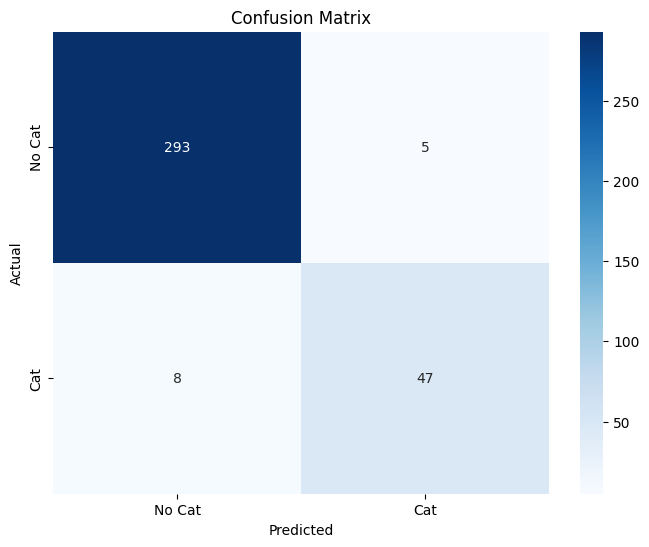

In [22]:
from sklearn.model_selection import train_test_split

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 2: Train the model on the training set (if not done earlier)
model.fit(X_train, y_train)

# Step 3: Predict on the test set
y_pred = model.predict(X_test)

# Step 4: Calculate performance metrics
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(y_true, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Call the evaluation function
evaluate_model(y_test, y_pred)

# Optional: Visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cat', 'Cat'], yticklabels=['No Cat', 'Cat'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

### Part 6: Sliding Window Detection Function

In [23]:

# Sliding window function to scan an image
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Function to detect cats in an image
def detect_cats_in_image(image, model, window_size=(128, 128), step_size=16):
    detections = []
    for (x, y, window) in sliding_window(image, step_size, window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue
        features = compute_hog_features(window).reshape(1, -1)
        prediction = model.predict(features)
        if prediction == 1:  # If detected as a cat
            detections.append((x, y, window_size[0], window_size[1]))  # Store bounding box
    return detections


### Part 7: Non-Max Suppression (to Clean Overlapping Detections)

In [24]:

# Apply non-maximum suppression to reduce overlapping boxes
def apply_nms(detections):
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in detections])
    return non_max_suppression(rects, probs=None, overlapThresh=0.3)


### Part 8: Visualization Function (to Display Detection Results)

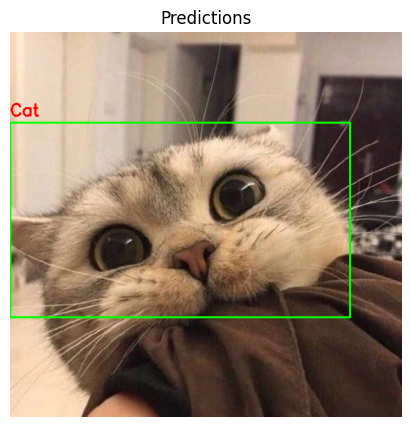

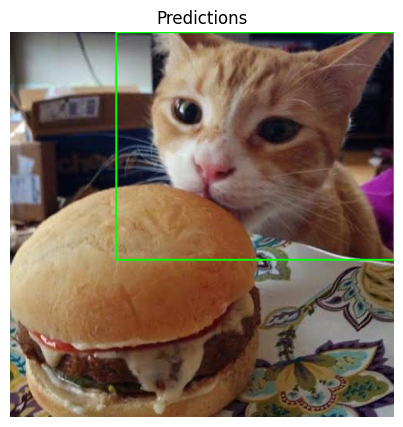

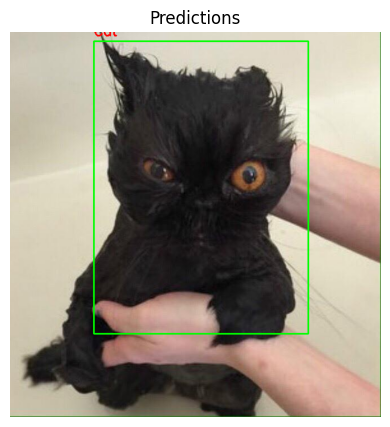

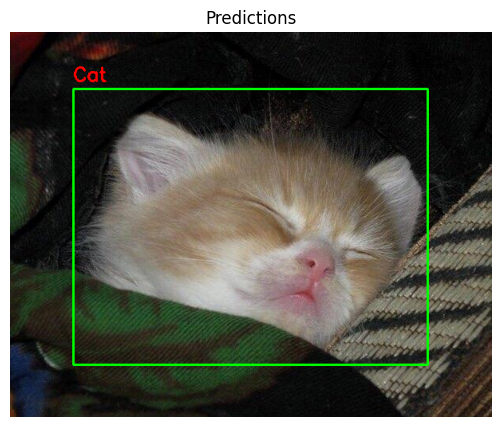

In [29]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

def parse_yolo_annotation(annotation_path, img_width, img_height):
    bboxes = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 5:  # Ensure there are enough parts
                class_id, x_center, y_center, width, height = map(float, parts)
                x_center, y_center, width, height = (
                    x_center * img_width,
                    y_center * img_height,
                    width * img_width,
                    height * img_height
                )
                x_min = int(x_center - width / 2)
                y_min = int(y_center - height / 2)
                x_max = int(x_center + width / 2)
                y_max = int(y_center + height / 2)
                bboxes.append((x_min, y_min, x_max, y_max))
    return bboxes

def visualize_predictions(image_dir, annotations_dir, predictions, limit=10):
    count = 0
    for annotation_path in glob.glob(os.path.join(annotations_dir, "*.txt")):
        image_path = os.path.join(image_dir, os.path.basename(annotation_path).replace('.txt', '.jpg'))
        image = cv2.imread(image_path)

        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        img_height, img_width = image.shape[:2]
        bboxes = parse_yolo_annotation(annotation_path, img_width, img_height)

        # Draw the actual bounding boxes on the original image
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, 'Cat', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        # Draw predicted bounding boxes (if any prediction exists)
        if count < len(predictions):
            pred = predictions[count]
            if pred == 1:  # Assuming 1 indicates the presence of a cat
                # Here you would typically call your detection function instead of directly using `pred`
                # Example: result = detect_cats_in_image(image)
                # This should return the bounding boxes for predicted cats
                for bbox in result:  # Assuming result is a list of bounding boxes [(x_min, y_min, x_max, y_max)]
                    x_min, y_min, x_max, y_max = bbox
                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Different color for predictions
                    cv2.putText(image, 'Detected Cat', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

        # Display the original image with bounding boxes
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Predictions')
        plt.show()

        count += 1
        if count >= limit:
            break

# Example usage (adjust with your actual directories)
# Replace these with your actual paths
test_image_dir = '/content/drive/MyDrive/dataset/test/images'
test_annotation_dir = '/content/drive/MyDrive/dataset/test/labels'
test_preds = []  # Replace with your actual predictions, for instance, from your detection model

visualize_predictions(test_image_dir, test_annotation_dir, test_preds, limit=4)
